## 5.1 リスク測度最小化によるポートフォリオ選択問題

### 平均絶対偏差値最小化問題

コード 5.1 pyfin_ad_portfolio.py

In [5]:
# -*- coding: utf-8 -*-
#%% NumPyの読み込み
import numpy as np
#   SciPyのstatsモジュールの読み込み
import scipy.stats as st
#   Pandasの読み込み
import pandas as pd
#%% 多変量正規分布からの乱数生成と保存
Mu = np.array([1.0, 3.0, 1.5, 6.0, 4.5])
Stdev = np.array([5.0, 10.0, 7.5, 15.0, 11.0])
CorrMatrix = np.array([[1.00, 0.25, 0.18, 0.10, 0.25],
                       [0.25, 1.00, 0.36, 0.20, 0.20],
                       [0.18, 0.36, 1.00, 0.25, 0.36],
                       [0.10, 0.20, 0.25, 1.00, 0.45],
                       [0.25, 0.20, 0.36, 0.45, 1.00]])
Sigma = np.diag(Stdev).dot(CorrMatrix).dot(np.diag(Stdev))
np.random.seed(9999)
T = 120
End_of_Month = pd.date_range('1/1/2007', periods=T, freq='M')
Asset_Names = [u'資産1', u'資産2', u'資産3', u'資産4', u'資産5']
Asset_Return = pd.DataFrame(st.multivariate_normal(Mu, Sigma).rvs(T),
                            index=End_of_Month, columns=Asset_Names)
Asset_Return.to_csv('asset_return_data.csv')

In [6]:
pip install cvxpy

Note: you may need to restart the kernel to use updated packages.


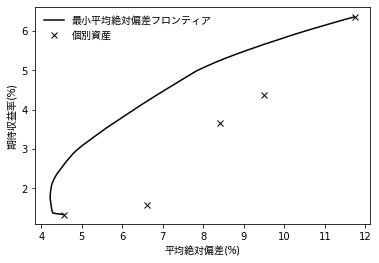

In [7]:
# -*- coding: utf-8 -*-
#%% NumPyの読み込み
import numpy as np
#   CVXPYの読み込み
import cvxpy as cvx
#   Pandasの読み込み
import pandas as pd
#   MatplotlibのPyplotモジュールの読み込み
import matplotlib.pyplot as plt
#   日本語フォントの設定
from matplotlib.font_manager import FontProperties
import sys
if sys.platform.startswith('win'):
    FontPath = 'C:\\Windows\\Fonts\\meiryo.ttc'
elif sys.platform.startswith('darwin'):
    FontPath = '/System/Library/Fonts/ヒラギノ角ゴシック W4.ttc'
elif sys.platform.startswith('linux'):
    FontPath = '/usr/share/fonts/truetype/takao-gothic/TakaoPGothic.ttf'
jpfont = FontProperties(fname=FontPath)
#%% 収益率データの読み込み
R = pd.read_csv('asset_return_data.csv', index_col=0)
T = R.shape[0]
N = R.shape[1]
Mu = R.mean().values
Return_Dev = (R - Mu).values / T
#%% 平均絶対偏差最小化問題の設定
Weight = cvx.Variable(N)
Deviation = cvx.Variable(T)
Target_Return = cvx.Parameter(nonneg=True)
Risk_AD = cvx.norm(Deviation, 1)
Opt_Portfolio = cvx.Problem(cvx.Minimize(Risk_AD),
                            [Return_Dev @ Weight == Deviation,
                             Weight.T @ Mu == Target_Return,
                             cvx.sum(Weight) == 1.0,
                             Weight >= 0.0])
#%% 最小平均絶対偏差フロンティアの計算
V_Target = np.linspace(Mu.min(), Mu.max(), num=250)
V_Risk = np.zeros(V_Target.shape)
for idx, Target_Return.value in enumerate(V_Target):
    Opt_Portfolio.solve(solver=cvx.ECOS)
    V_Risk[idx] = Risk_AD.value
#%% 最小平均絶対偏差フロンティアのグラフの作成
fig1 = plt.figure(1, facecolor='w')
plt.plot(V_Risk, V_Target, 'k-')
plt.plot((R - Mu).abs().mean().values, Mu, 'kx')
plt.legend([u'最小平均絶対偏差フロンティア', u'個別資産'],
           loc='best', frameon=False, prop=jpfont)
plt.xlabel(u'平均絶対偏差(%)', fontproperties=jpfont)
plt.ylabel(u'期待収益率(%)', fontproperties=jpfont)
plt.show()